# Figure 4: RGC density and responsiveness in *wild-type* and *rd10* across age

# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statannotations.Annotator import Annotator
import data_plots

# --------------------------------------------------------------------

# Load data

In [84]:
file_path = '../data'  # Adjust path to file if necessary
file_name = 'rd10_all_data.h5'
joined_path = os.path.join(file_path, file_name)
rd10_df = pd.read_hdf(joined_path, key='df')

In [8]:
rd10_df.keys()

Index(['experimenter', 'date', 'exp_num', 'field', 'roi_id', 'preproc_chirp',
       'preproc_bar', 'animgender', 'celltype', 'max_confidence',
       'roi_size_um2', 'gchirp_on_off_index', 'gchirp_transience_index',
       'bar_ds_index', 'bar_ds_pvalue', 'bar_pref_dir', 'bar_os_index',
       'bar_os_pvalue', 'bar_pref_or', 'bar_d_qi', 'gchirp_qidx', 'animrem',
       'genline'],
      dtype='object')

# --------------------------------------------------------------------

# Helper functions



In [9]:
def plot_test(ax, df, x, y, order, pairs, test="mann-whitney", hue=None, hue_order=None, palette=None, marker=None,
              ylabel=None):
    sns.boxplot(ax=ax, data=df, x=x, y=y, fliersize=0, palette=palette, order=order, hue=hue, hue_order=hue_order)

    annotator = Annotator(ax=ax, pairs=pairs, plot='boxplot', data=df, x=x, y=y, order=order, hue=hue,
                          hue_order=hue_order)
    annotator.configure(test=test, comparisons_correction="BH" if len(order) > 2 else None,
                        text_format='star', loc='outside', verbose=2,
                        text_offset=-0.1, fontsize=9, line_height=0.02, line_offset=0.0, line_width=1)
    annotator.apply_test().annotate(line_offset_to_group=0.02, line_offset=0.01)

    if ylabel is not None:
        ax.set_ylabel(ylabel)

# --------------------------------------------------------------------

# Number of cells per age

In [10]:
# restrict per age
## wild-type
all_wt_p30 = rd10_df[(rd10_df['animrem'] == 'P30') & (rd10_df['genline'] == 'Bl6')].values.shape[0]
all_wt_p45 = rd10_df[(rd10_df['animrem'] == 'P45') & (rd10_df['genline'] == 'Bl6')].values.shape[0]
all_wt_p90 = rd10_df[(rd10_df['animrem'] == 'P90') & (rd10_df['genline'] == 'Bl6')].values.shape[0]
all_wt_p180 = rd10_df[(rd10_df['animrem'] == 'P180') & (rd10_df['genline'] == 'Bl6')].values.shape[0]
all_wt = rd10_df[(rd10_df['genline'] == 'Bl6')].values.shape[0]

## rd10
all_rd_p30 = rd10_df[(rd10_df['animrem'] == 'P30') & (rd10_df['genline'] == 'rd10')].values.shape[0]
all_rd_p45 = rd10_df[(rd10_df['animrem'] == 'P45') & (rd10_df['genline'] == 'rd10')].values.shape[0]
all_rd_p90 = rd10_df[(rd10_df['animrem'] == 'P90') & (rd10_df['genline'] == 'rd10')].values.shape[0]
all_rd_p180 = rd10_df[(rd10_df['animrem'] == 'P180') & (rd10_df['genline'] == 'rd10')].values.shape[0]
all_rd = rd10_df[(rd10_df['genline'] == 'rd10')].values.shape[0]

# --------------------------------------------------------------------

# Make alpha cell dataframe and calculate percent of alpha cells per field

In [11]:
alpha_cells_df = rd10_df[rd10_df['roi_size_um2'] >= 136]

In [12]:
dates = []
animrems = []
genlines = []
exp_nums = []
fields = []
alphas = []
n_roiss = []

for (date, exp_num, field, genline, animrem), df_field in rd10_df.groupby(
        ['date', 'exp_num', 'field', 'genline', 'animrem']):
    alpha = (df_field['roi_size_um2'] >= 136).sum()
    n_rois = len(df_field['roi_id'])

    alphas.append(alpha)
    n_roiss.append(n_rois)

    # Accumulate values for each iteration
    dates.append(date)
    animrems.append(animrem)
    genlines.append(genline)
    exp_nums.append(exp_num)
    fields.append(field)

# Create a DataFrame after the loop
alpha_df = pd.DataFrame({
    'date': dates,
    'animrem': animrems,
    'genline': genlines,
    'exp_num': exp_nums,
    'field': fields,
    'alphas': alphas,
    'n_cells': n_roiss,
})

# Calculate percentages
alpha_df['alpha_percentage'] = (alpha_df['alphas'] / alpha_df['n_cells']) * 100

alpha_df

,date,animrem,genline,exp_num,field,alphas,n_cells,alpha_percentage
0,2021-05-20,P90,Bl6,1,GCL1,9,120,7.500000
1,2021-05-20,P90,Bl6,1,GCL2,6,116,5.172414
2,2021-05-20,P90,Bl6,1,GCL3,9,92,9.782609
3,2021-05-20,P90,Bl6,1,GCL4,15,72,20.833333
4,2021-05-20,P90,Bl6,1,GCL5,11,78,14.102564
...,...,...,...,...,...,...,...,...
332,2024-01-25,P30,rd10,2,GCL4,9,109,8.256881
333,2024-01-25,P30,rd10,2,GCL5,6,125,4.800000
334,2024-01-25,P30,rd10,2,GCL6,5,105,4.761905
335,2024-01-25,P30,rd10,2,GCL7,6,108,5.555556


# --------------------------------------------------------------------

# Responsive cells per field

In [13]:
roi_qs = []
n_roiss = []
dates = []
animrems = []
genlines = []
exp_nums = []
fields = []

for (date, exp_num, field, genline, animrem), df_field in rd10_df.groupby(
        ['date', 'exp_num', 'field', 'genline', 'animrem']):
    roi_q = np.sum((df_field['gchirp_qidx'] >= 0.35) | (df_field['bar_d_qi'] >= 0.6))
    n_rois = len(df_field['roi_id'])

    roi_qs.append(roi_q)
    n_roiss.append(n_rois)

    # Accumulate values for each iteration
    dates.append(date)
    animrems.append(animrem)
    genlines.append(genline)
    exp_nums.append(exp_num)
    fields.append(field)

# Create a DataFrame after the loop
result_df = pd.DataFrame({
    'date': dates,
    'animrem': animrems,
    'genline': genlines,
    'exp_num': exp_nums,
    'field': fields,
    'n_cells': n_roiss,
    'resp_cells': roi_qs,
})

# Calculate percentages
result_df['resp_percentage'] = (result_df['resp_cells'] / result_df['n_cells']) * 100

result_df

,date,animrem,genline,exp_num,field,n_cells,resp_cells,resp_percentage
0,2021-05-20,P90,Bl6,1,GCL1,120,84,70.000000
1,2021-05-20,P90,Bl6,1,GCL2,116,96,82.758621
2,2021-05-20,P90,Bl6,1,GCL3,92,0,0.000000
3,2021-05-20,P90,Bl6,1,GCL4,72,29,40.277778
4,2021-05-20,P90,Bl6,1,GCL5,78,10,12.820513
...,...,...,...,...,...,...,...,...
332,2024-01-25,P30,rd10,2,GCL4,109,59,54.128440
333,2024-01-25,P30,rd10,2,GCL5,125,102,81.600000
334,2024-01-25,P30,rd10,2,GCL6,105,89,84.761905
335,2024-01-25,P30,rd10,2,GCL7,108,68,62.962963


# --------------------------------------------------------------------

# Plot

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

P45_Bl6 vs. P45_rd10: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.866e-02 U_stat=1.664e+03
P30_Bl6 vs. P30_rd10: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.167e-03 U_stat=9.915e+02
P90_Bl6 vs. P90_rd10: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.415e-01 U_stat=1.446e+03
P180_Bl6 vs. P180_rd10: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.120e-01 U_stat=2.585e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

P45_Bl6 vs. P45_rd10: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6

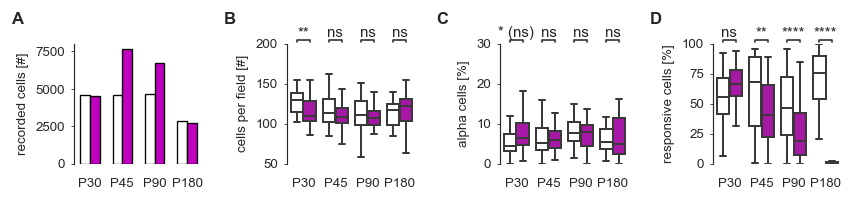

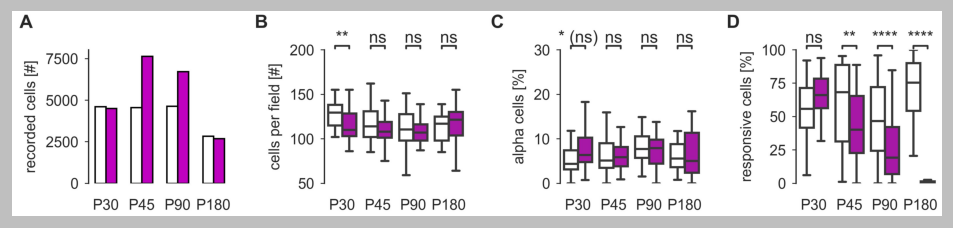

In [14]:
# Set context
data_plots.set_rc_params(kind='paper', notebook_dpi=120)

# Create plot
fig, axs = plt.subplots(1, 4)

# Set size
data_plots.set_figsize(fig, 'full', height_ratio=0.22)
data_plots.set_labs(axs, panel_nums='auto', panel_num_pad=10, panel_num_space=11)

# Tweaking
data_plots.move_xaxis_outward(axs)

x_order = ['P30', 'P45', 'P90', 'P180']

# total number of cells
axs[0].bar(np.arange(0, 4, 1) - 0.15, [all_wt_p30, all_wt_p45, all_wt_p90, all_wt_p180], width=0.3, edgecolor='k',
           color='w', label='wt')
axs[0].bar(np.arange(0, 4, 1) + 0.15, [all_rd_p30, all_rd_p45, all_rd_p90, all_rd_p180], width=0.3, edgecolor='k',
           color='m', label='rd10')
axs[0].set_ylabel('recorded cells [#]')
axs[0].spines['bottom'].set_visible(False)
axs[0].tick_params(axis='x', which='both', bottom=False)
axs[0].xaxis.set_major_locator(plt.NullLocator())  # Remove major ticks from x-axis
axs[0].spines['bottom'].set_color('white')  # Set x-axis color to white
axs[0].set_xlabel('')
# Set the xticks and labels
axs[0].set_xticks(range(len(x_order)))
axs[0].set_xticklabels(x_order)

# cells per field
x_order = ['P30', 'P45', 'P90', 'P180']
hue_order = ['Bl6', 'rd10']
pairs = [[(xi, hi) for hi in hue_order] for xi in x_order]
# Create the subplot before setting ylim
axs[1].plot([])  # An empty plot to create the subplot
axs[1].set_ylim(50, 200)  # Set the y-axis limits
ax = plot_test(ax=axs[1], df=result_df, x='animrem', y="n_cells", ylabel='cells per field [#]', order=x_order,
               pairs=pairs, test="Mann-Whitney", hue='genline', palette={'Bl6': 'w', 'rd10': 'm'})
axs[1].set_ylabel('cells per field [#]')
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', which='both', bottom=False)
axs[1].xaxis.set_major_locator(plt.NullLocator())  # Remove major ticks from x-axis
axs[1].spines['bottom'].set_color('white')  # Set x-axis color to white
# Set the xticks and labels
axs[1].set_xticks(range(len(x_order)))
axs[1].set_xticklabels(x_order)

# alpha cells
hue_order = ['Bl6', 'rd10']
pairs = [[(xi, hi) for hi in hue_order] for xi in x_order]
# Create the subplot before setting ylim
axs[2].plot([])  # An empty plot to create the subplot
axs[2].set_ylim(0, 30)  # Set the y-axis limits
ax = plot_test(ax=axs[2], df=alpha_df, x='animrem', y="alpha_percentage", ylabel='alpha cells per field [%]',
               order=x_order, pairs=pairs, test="Mann-Whitney", hue='genline', palette={'Bl6': 'w', 'rd10': 'm'})
axs[2].set(xlabel=None)
sns.despine()
axs[2].tick_params(axis='x', which='both', bottom=False, labelbottom=True)
axs[2].spines['bottom'].set_visible(False)
axs[2].xaxis.set_major_locator(plt.NullLocator())  # Remove major ticks from x-axis
axs[2].spines['bottom'].set_color('white')  # Set x-axis color to white
axs[2].set_ylabel('alpha cells [%]')
# Set the xticks and labels
axs[2].set_xticks(range(len(x_order)))
axs[2].set_xticklabels(x_order)

# responsive cells
x_order = ['P30', 'P45', 'P90', 'P180']
hue_order = ['Bl6', 'rd10']
pairs = [[(xi, hi) for hi in hue_order] for xi in x_order]
# Create the subplot before setting ylim
axs[3].plot([])  # An empty plot to create the subplot
axs[3].set_ylim(0, 100)  # Set the y-axis limits
ax = plot_test(ax=axs[3], df=result_df, x='animrem', y="resp_percentage", ylabel='responsive cells [%]', order=x_order,
               pairs=pairs, marker='o', test="Mann-Whitney", hue='genline', palette={'Bl6': 'w', 'rd10': 'm'})
axs[3].get_legend().remove()
axs[3].set_ylabel('responsive cells [%]')
axs[3].set(xlabel=None)
sns.despine()
axs[3].tick_params(axis='x', which='both', bottom=False, labelbottom=True)
axs[3].spines['bottom'].set_visible(False)
axs[3].set_ylabel('responsive cells [%]')
axs[3].xaxis.set_major_locator(plt.NullLocator())  # Remove major ticks from x-axis
axs[3].spines['bottom'].set_color('white')  # Set x-axis color to white
# Set the xticks and labels
axs[3].set_xticks(range(len(x_order)))
axs[3].set_xticklabels(x_order)

#legend
axs[0].legend([], [], frameon=False, fontsize=8)
axs[1].legend([], [], frameon=False, fontsize=8)
axs[2].legend([], [], frameon=False, fontsize=8)
axs[3].legend([], [], frameon=False, fontsize=8)

# Similar to standard tight_layout, but relative to fontsize used
data_plots.tight_layout(rect=(0.01, 0, 1, 1), w_pad=2.6, h_pad=1.5)

#plt.savefig('Fig3_2024-05-23.png')

# Make sure nothing is cut off, when saving
# Avoid using bbox_inches='tight', because it will resize the figure
data_plots.show_saved_figure(fig)